# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Computer-Specs" data-toc-modified-id="Computer-Specs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Computer Specs</a></div><div class="lev1 toc-item"><a href="#Get-Data" data-toc-modified-id="Get-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get Data</a></div><div class="lev1 toc-item"><a href="#DF-to-HDF5-Conversion" data-toc-modified-id="DF-to-HDF5-Conversion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DF to HDF5 Conversion</a></div><div class="lev1 toc-item"><a href="#File-Sizes" data-toc-modified-id="File-Sizes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>File Sizes</a></div><div class="lev2 toc-item"><a href="#Original" data-toc-modified-id="Original-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Original</a></div><div class="lev2 toc-item"><a href="#Compressed" data-toc-modified-id="Compressed-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Compressed</a></div><div class="lev2 toc-item"><a href="#Barplots" data-toc-modified-id="Barplots-53"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Barplots</a></div><div class="lev1 toc-item"><a href="#spy()" data-toc-modified-id="spy()-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>spy()</a></div><div class="lev1 toc-item"><a href="#In-Memory-Compression" data-toc-modified-id="In-Memory-Compression-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>In-Memory Compression</a></div><div class="lev1 toc-item"><a href="#Machine-Learning" data-toc-modified-id="Machine-Learning-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Machine Learning</a></div>

# Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import h5py
import cpuinfo
from __future__ import print_function

# Computer Specs

In [2]:
info = cpuinfo.get_cpu_info()
entries = ('flags', 'count', 'cpuinfo_version', 'family', 'hz_actual', 'hz_actual_raw', 'hz_advertised', 
          'hz_advertised_raw', 'model', 'raw_arch_string', 'stepping')
for key in entries:
        if key in info:
            del info[key]
info

{'arch': 'X86_64',
 'bits': 64,
 'brand': 'Intel(R) Core(TM) i7-5557U CPU @ 3.10GHz',
 'l2_cache_size': '256',
 'vendor_id': 'GenuineIntel'}

**NOTE: I am using Python 2.7. StringIO is not available in Python 3.**

# Get Data

The zip file from UCI includes two files, one train and one test. Pandas has zip/unzip functionality but cannot handle zip files with greater than one data object, like in this case. Instead I had to preprocess the data to prep it for pandas. Here is my code.

In [3]:
# get zip data from UCI
import requests, zipfile, StringIO
r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00367/dota2Dataset.zip")
z = zipfile.ZipFile(StringIO.StringIO(r.content))

Now we can read the datasets into pandas like so:

In [4]:
# get train data
X_train = pd.read_csv(z.open('dota2Train.csv'), header=None)
# get test data
X_test = pd.read_csv(z.open('dota2Test.csv'), header=None)

In [5]:
# Check df shapes
print("train", X_train.shape)
print("test ", X_test.shape)

train (92650, 117)
test  (10294, 117)


In [6]:
# get in-memory object size
print(X_train.info())
print("")
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92650 entries, 0 to 92649
Columns: 117 entries, 0 to 116
dtypes: int64(117)
memory usage: 82.7 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10294 entries, 0 to 10293
Columns: 117 entries, 0 to 116
dtypes: int64(117)
memory usage: 9.2 MB
None


I will show below that the original training data CSV is about 22.4 MB. However, note that in-memory usage is significantly higher. In this case we went from 22.4 MB on-disk to 82.7 MB in-memory. Remember that when you are dealing with large files as you may not have enough RAM to hold large data in-memory.

# DF to HDF5 Conversion

Let's convert these dataframes into HDF5 using three compressors set to max compression.

In [7]:
# create H5 files for each compressor on max compression
compressors = ['blosc', 'bzip2', 'zlib']
for compressor in compressors:
    X_train.to_hdf('/Users/davidziganto/Desktop/data/dota2Dataset/dota2Train_' + str(compressor) + '.h5', 
                   'table', mode='w', append=True, complevel=9, complib=compressor, fletcher32=True)
    X_test.to_hdf('/Users/davidziganto/Desktop/data/dota2Dataset/dota2Test_' + str(compressor) + '.h5', 
                   'table', mode='w', append=True, complevel=9, complib=compressor, fletcher32=True)

In [8]:
# remove dataframes to show we can read them back in effortlessly
del X_train, X_test

In [9]:
# read in dataframes from compressed HDF5 files
X_train = pd.read_hdf('/Users/davidziganto/Desktop/data/dota2Dataset/dota2Train_zlib.h5', 'table')
X_test = pd.read_hdf('/Users/davidziganto/Desktop/data/dota2Dataset/dota2Test_zlib.h5', 'table')

In [10]:
# get in-memory object size after being read in
print(X_train.info())
print("")
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92650 entries, 0 to 92649
Columns: 117 entries, 0 to 116
dtypes: int64(117)
memory usage: 83.4 MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10294 entries, 0 to 10293
Columns: 117 entries, 0 to 116
dtypes: int64(117)
memory usage: 9.3 MB
None


I will show in the next section just how much we were able to compress the data on-disk, but it is important to note that the data gets decompressed when read back into memory. In fact, the memory usage is ever so slightly higher than when we read in the raw file from UCI. So while we can leverage on-disk compression, this method does not compress the data in-memory. Remember that.

# File Sizes

## Original

In [11]:
# get original file size (in MB)
import os
original_size = []
datasets = ['Train', 'Test']
for dataset in datasets:
    original_size.append( round(os.path.getsize("/Users/davidziganto/Desktop/data/dota2Dataset/dota2" + str(dataset) + ".csv")/1e6, 2) )
original_data_size = zip(datasets, original_size)

In [12]:
original_data_size

[('Train', 22.37), ('Test', 2.49)]

## Compressed

In [13]:
# get compressed file sizes (in MB)
compressed_size = []
for compressor in compressors:
    for dataset in datasets:
        compressed_size.append( round(os.path.getsize("/Users/davidziganto/Desktop/data/dota2Dataset/dota2" 
                                                      + dataset + "_" + str(compressor) + ".h5")/1e6, 2) )
compressed_data_size = zip(sorted(['blosc', 'bzip2', 'zlib']*2), ['train', 'test']*3, compressed_size)

In [14]:
compressed_data_size

[('blosc', 'train', 8.11),
 ('blosc', 'test', 0.64),
 ('bzip2', 'train', 2.57),
 ('bzip2', 'test', 0.34),
 ('zlib', 'train', 2.6),
 ('zlib', 'test', 0.32)]

## Barplots

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# get sizes of compressed objects
train_compressed_size = [compressed_data_size[i][2] for i in range(0,len(compressed_data_size),2)]
test_compressed_size = [compressed_data_size[i][2] for i in range(1,len(compressed_data_size),2)]
# append original size values
train_compressed_size.append(original_data_size[0][1])  ## append original train data size
test_compressed_size.append(original_data_size[1][1])  ## append original test size
# reorder list
myorder=[3,0,1,2]
train_compressed_size = [ train_compressed_size[i] for i in myorder]
test_compressed_size = [ test_compressed_size[i] for i in myorder]

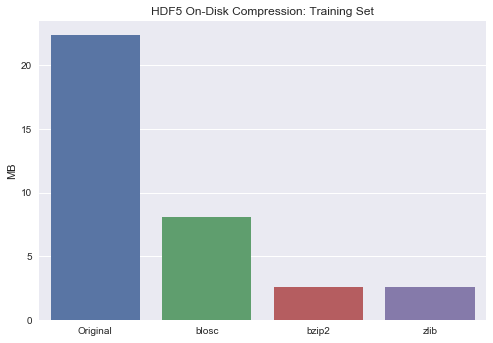

In [17]:
sns.barplot(['Original', 'blosc', 'bzip2', 'zlib'], train_compressed_size)
plt.ylabel('MB')
plt.title('HDF5 On-Disk Compression: Training Set');
#plt.savefig('/Users/davidziganto/Desktop/hdf5_train_compression.png')

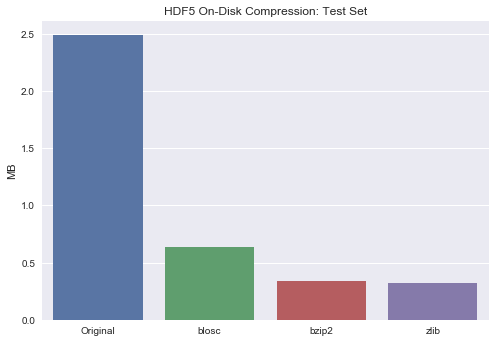

In [18]:
sns.barplot(['Original', 'blosc', 'bzip2', 'zlib'], test_compressed_size)
plt.ylabel('MB')
plt.title('HDF5 On-Disk Compression: Test Set');
#plt.savefig('/Users/davidziganto/Desktop/hdf5_test_compression.png')

In [19]:
# calc object size as proportion of original train object size
np.array(train_compressed_size)/train_compressed_size[0]

array([ 1.        ,  0.36253911,  0.11488601,  0.11622709])

In [20]:
# calc object size as proportion of original test object size
np.array(test_compressed_size)/test_compressed_size[0]

array([ 1.        ,  0.25702811,  0.13654618,  0.12851406])

You will notice that bzip2 and zlib compress the data to roughly the same extent. Blosc, on the other hand, does result in significant compression but not to the same extent as bzip2 or zlib. Why is that? Turns out there exists this tradeoff between total compression and read/write times. Zlib and bzip2 are great if your main concern is on-disk storage. If your primary concern is read/write times but you still want to leverage on-disk compression, use blosc. 

# spy()

Use spy() to get a sense of the data's sparsity. Since the data is long and skinny, I transpose it so we can get a better view in the notebook. Also, I am only capturing the first 1000 rows. Why? Because the dimensions of the dataset are highly skewed which causes the image to get compressed. In other words, the visualization gets crunched so bad that we cannot discern anything useful.

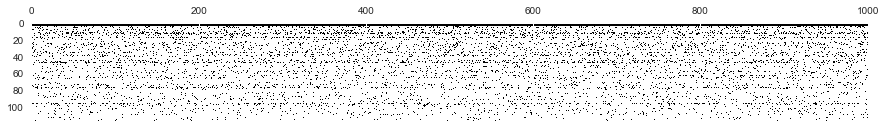

In [21]:
fig = plt.figure(figsize=(15,8))
plt.spy(X_train.transpose().ix[:, :1000]);
#plt.savefig('/Users/davidziganto/Desktop/dota2_spy.png')

You can see the data is very sparse in all but the first three features.

# In-Memory Compression

In [22]:
X_train.shape

(92650, 117)

In [23]:
# Preprocessing

#separate target var from dataset
y_train = X_train.pop(0)
y_test = X_test.pop(0)
# change indicator values from -1, 0, 1 to 0, 1
X_train = X_train.abs()
X_test = X_test.abs()

Let's use CSR to compress this dataset in-memory and compare data footprints.

In [24]:
from scipy.sparse import csr_matrix
X_train_sparse = csr_matrix(X_train)
X_test_sparse = csr_matrix(X_train)

In [25]:
dense_size = np.array(X_train).nbytes/1e6
sparse_size = (X_train_sparse.data.nbytes + X_train_sparse.indptr.nbytes + X_train_sparse.indices.nbytes)/1e6
print(" dense:", round(dense_size, 2), "MB")
print("sparse:", round(sparse_size, 2), "MB")
print("")
print("Compression: %.1f%% " % round((1 - sparse_size/dense_size) * 100, 1))

 dense: 85.98 MB
sparse: 14.82 MB

Compression: 82.8% 


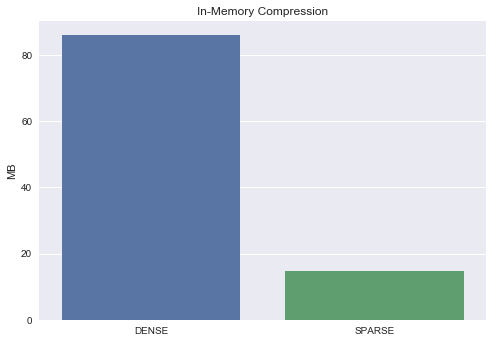

In [26]:
sns.barplot(['DENSE', 'SPARSE'], [dense_size, sparse_size])
plt.ylabel('MB')
plt.title('In-Memory Compression');
#plt.savefig('/Users/davidziganto/Desktop/dota2_in_memory_compression.png')

On this real dataset we were able to compress the data both on-disk and in-memory.

# Machine Learning

In [27]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB(alpha=1.0, binarize=None, fit_prior=True, class_prior=None)

In [28]:
%timeit nb.fit(X_train, y_train)

10 loops, best of 3: 58.6 ms per loop


In [29]:
%timeit nb.fit(X_train_sparse, y_train)

10 loops, best of 3: 22.6 ms per loop


In [30]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(C=1.0, fit_intercept=True, n_iter=5, 
                                  shuffle=True, verbose=0, loss='hinge', 
                                  n_jobs=-11, random_state=12, warm_start=False, 
                                  class_weight=None)

In [31]:
%timeit pac.fit(X_train, y_train)

1 loop, best of 3: 302 ms per loop


In [32]:
%timeit pac.fit(X_train_sparse, y_train)

10 loops, best of 3: 122 ms per loop


In [33]:
from sklearn.linear_model import Perceptron
percept = Perceptron(penalty='l2', alpha=0.001, fit_intercept=True, 
                     n_iter=20, shuffle=True, verbose=0, eta0=1.0, n_jobs=-1, 
                     random_state=37, class_weight=None, warm_start=False)

In [34]:
%timeit percept.fit(X_train, y_train)

1 loop, best of 3: 893 ms per loop


In [35]:
%timeit percept.fit(X_train_sparse, y_train)

1 loop, best of 3: 432 ms per loop


Algorithm | Dense Time | Sparse Time
------------ | -------------
BernoulliNB | 58.6 ms | 22.6 ms
PAC | 302 ms | 122 ms
Perceptron | 893 ms | 432 ms

In [38]:
ml = {'algo': ["BernoulliNB", "BernoulliNB", "PAC", "PAC", "Perceptron", "Perceptron"],
     'matrix type': ['dense', 'sparse', 'dense', 'sparse', 'dense', 'sparse'],
     'value': [58.6, 22.6, 302, 122, 893, 432]}
df = pd.DataFrame(ml)

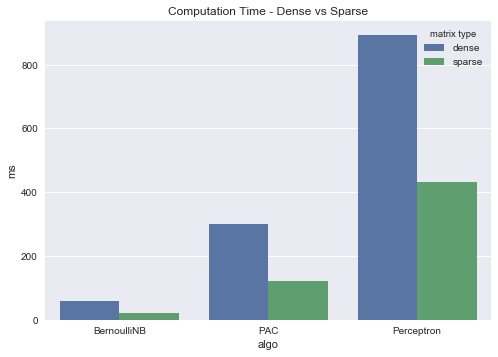

In [39]:
sns.barplot(x="algo", y='value', hue='matrix type', data=df)
plt.ylabel('ms')
plt.title('Computation Time - Dense vs Sparse');
#plt.savefig('/Users/davidziganto/Desktop/dota2_algo_timing.png')

In case you needed reminding that sparse matrices can speed up machine learning algorithms, see the table above. Quite a stark contrast. Again, this is a real dataset that was pulled from the UCI Machine Learning Repo. This isn't some contrived example. Test it for yourself.